# Multi-Touch Attribution Analysis

## Overview
This notebook implements six attribution models to understand how different marketing channels contribute to customer conversions:

1. **First-Touch Attribution** - Credits the first touchpoint in a customer journey
2. **Last-Touch Attribution** - Credits the last touchpoint before conversion
3. **Linear Attribution** - Distributes credit evenly across all touchpoints
4. **U-shaped Attribution** - 40% credit to first and last touchpoints, 20% to middle touchpoints
5. **Data-Driven Attribution** - Uses logistic regression to assign credit based on statistical significance
6. **Random Forest Attribution** - Uses tree-based machine learning to identify complex patterns

## Data Science Components
This notebook follows a standard data science workflow:
1. Data Collection & Generation
2. Data Preprocessing
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Modeling
6. Evaluation & Comparison

In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set plotting style
# Use a compatible style that works across matplotlib versions
try:
    plt.style.use('seaborn-whitegrid')  # For older matplotlib versions
except:
    try:
        plt.style.use('seaborn-v0_8-whitegrid')  # For newer matplotlib versions
    except:
        plt.style.use('seaborn')  # Fallback to basic seaborn style

sns.set_palette("Blues_d")

## 1. Importing Dataset


In [33]:
file_id = '1gC1TCPAy6C1YCbXtLWKgG0j1ILp4lr5V'
url = f'https://drive.google.com/uc?id={file_id}'
df_raw = pd.read_csv(url, usecols=['user_id', 'touchpoint', 'timestamp', 'conversion'])
print(f"Generated data with {len(df_raw)} touchpoints for 1000 users")
print(df_raw.head())

Generated data with 2930 touchpoints for 1000 users
   user_id touchpoint   timestamp  conversion
0        1     search  2023-03-13           0
1        1     social  2023-04-17           0
2        1     search  2023-09-28           0
3        1      video  2023-12-15           0
4        2     search  2023-03-29           0


## 2. Data Preprocessing

Next, we'll clean and structure the data for analysis.

In [34]:
# 1. Sort touchpoints chronologically for each user
df = df_raw.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

# 2. Check for missing values
print("Missing values in the dataset:")
print(df.isnull().sum())

# 3. Format timestamp to ensure consistency
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 4. Calculate the position of each touchpoint in its user journey
df['touchpoint_position'] = df.groupby('user_id').cumcount() + 1
df['journey_length'] = df.groupby('user_id')['user_id'].transform('count')

# 5. Create is_first and is_last flags for easier identification
df['is_first_touch'] = df['touchpoint_position'] == 1
df['is_last_touch'] = df['touchpoint_position'] == df['journey_length']

print("\nPreprocessing complete. Sample of processed data:")
print(df.head())

Missing values in the dataset:
user_id       0
touchpoint    0
timestamp     0
conversion    0
dtype: int64

Preprocessing complete. Sample of processed data:
   user_id touchpoint  timestamp  conversion  touchpoint_position  \
0        1     search 2023-03-13           0                    1   
1        1     social 2023-04-17           0                    2   
2        1     search 2023-09-28           0                    3   
3        1      video 2023-12-15           0                    4   
4        2     search 2023-03-29           0                    1   

   journey_length  is_first_touch  is_last_touch  
0               4            True          False  
1               4           False          False  
2               4           False          False  
3               4           False           True  
4               2            True          False  


## 3. Exploratory Data Analysis (EDA)

Now we'll explore the processed data to understand distributions and patterns.

Total number of data points: 2930
Number of unique users: 1000

Touchpoint distribution:
touchpoint
search       1014
social        577
email         515
display       449
affiliate     234
video         141
Name: count, dtype: int64

Touchpoint distribution (%):
touchpoint
search       34.6%
social       19.7%
email        17.6%
display      15.3%
affiliate     8.0%
video         4.8%
Name: proportion, dtype: object

Journey length distribution:
journey_length
1    221
2    412
3    567
4    760
5    970
Name: count, dtype: int64

Average touchpoints per user: 3.63

Conversion summary:
Total conversions: 194
Conversion rate: 19.40%


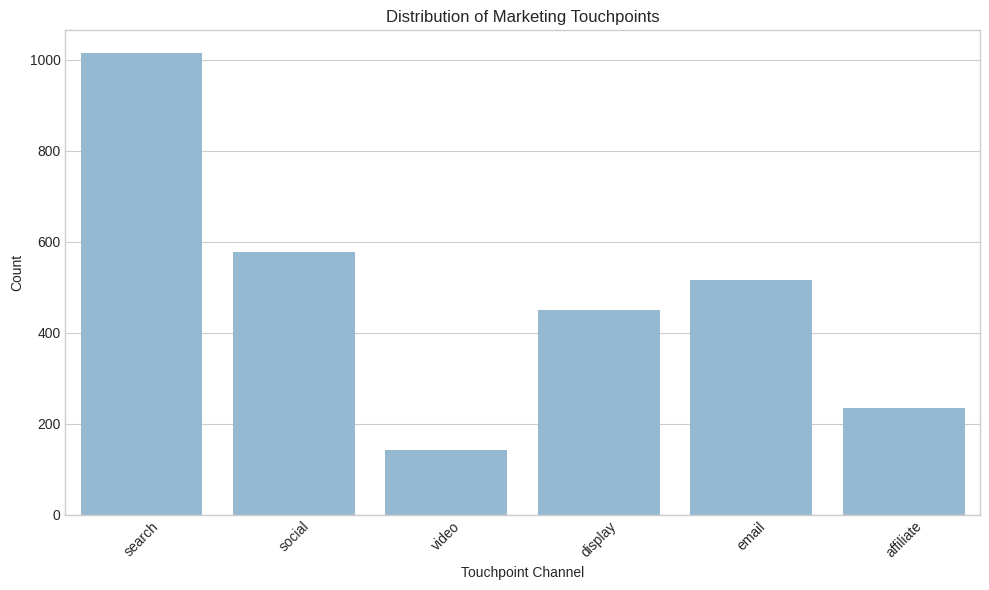

In [35]:
# Basic dataset statistics
print(f"Total number of data points: {len(df)}")
print(f"Number of unique users: {df['user_id'].nunique()}")

# Touchpoint distribution
print("\nTouchpoint distribution:")
touchpoint_counts = df['touchpoint'].value_counts()
print(touchpoint_counts)
print(f"\nTouchpoint distribution (%):")
print(df['touchpoint'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

# Journey length analysis
print("\nJourney length distribution:")
journey_lengths = df['journey_length'].value_counts().sort_index()
print(journey_lengths)
print(f"\nAverage touchpoints per user: {df['journey_length'].mean():.2f}")

# Conversion analysis
conversions = df[df['conversion'] == 1]
print("\nConversion summary:")
print(f"Total conversions: {len(conversions)}")
print(f"Conversion rate: {len(conversions) / df['user_id'].nunique():.2%}")

# Visualize touchpoint distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='touchpoint', data=df)
plt.title('Distribution of Marketing Touchpoints')
plt.xlabel('Touchpoint Channel')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Feature Engineering

Prepare the data for our attribution models by creating appropriate features.

In [36]:
# 1. Prepare features for basic attribution models
first_touches = df[df['is_first_touch']]['touchpoint'].value_counts()
last_touches = df[df['is_last_touch']]['touchpoint'].value_counts()

# 2. Prepare features for ML models (logistic regression)
# Create one-hot encoded touchpoints for each user
def prepare_ml_features(df):
    touchpoints = ['email', 'social', 'search', 'display', 'video', 'affiliate']
    user_journeys = df.groupby('user_id')['touchpoint'].apply(list).reset_index()
    user_journeys['conversion'] = df.groupby('user_id')['conversion'].last().values

    # Create feature matrix
    feature_matrix = np.zeros((len(user_journeys), len(touchpoints)))

    for idx, journey in enumerate(user_journeys['touchpoint']):
        for touchpoint in journey:
            feature_matrix[idx, touchpoints.index(touchpoint)] = 1

    return feature_matrix, user_journeys['conversion'].values, touchpoints

# 3. Prepare features for Random Forest
def prepare_rf_features(df):
    # Label encode touchpoints
    le = LabelEncoder()
    df_encoded = df.copy()
    df_encoded['touchpoint_encoded'] = le.fit_transform(df['touchpoint'])

    # Create sequence and timing features
    features = df_encoded.groupby('user_id').apply(
        lambda group: pd.Series({
            'sequence': group['touchpoint_encoded'].tolist(),
            'time_diff': (group['timestamp'].max() - group['timestamp'].min()).total_seconds() / 3600,
            'conversion': group['conversion'].iloc[-1]
        })
    )

    # Pad sequences to same length
    max_length = features['sequence'].apply(len).max()
    X = np.array([seq + [0] * (max_length - len(seq)) for seq in features['sequence']])

    # Add time difference feature
    X = np.column_stack([X, features['time_diff'].values])

    return X, features['conversion'].values, le

# Prepare features for our models
ml_features, ml_target, touchpoint_names = prepare_ml_features(df)
rf_features, rf_target, label_encoder = prepare_rf_features(df)

print("Feature engineering complete.")
print(f"ML features shape: {ml_features.shape}")
print(f"RF features shape: {rf_features.shape}")

Feature engineering complete.
ML features shape: (1000, 6)
RF features shape: (1000, 6)


<ipython-input-36-49efb2eb2713>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features = df_encoded.groupby('user_id').apply(


## 5. Attribution Models Implementation

Implement and evaluate all six attribution models.

In [37]:
# Helper function to calculate attribution
def calculate_attribution(attribution_dict):
    """Normalize attribution values to sum to 1"""
    total = sum(attribution_dict.values())
    return {channel: value / total for channel, value in attribution_dict.items()}

# 1. First-Touch Attribution Model
def first_touch_attribution(df):
    """Attribute conversion to the first touchpoint in each user journey"""
    first_touches = df[df['is_first_touch']]['touchpoint'].value_counts()
    return calculate_attribution(first_touches.to_dict())

########################################################################################################################################################################################

# 2. Last-Touch Attribution Model
def last_touch_attribution(df):
    """Attribute conversion to the last touchpoint in each user journey"""
    last_touches = df[df['is_last_touch']]['touchpoint'].value_counts()
    return calculate_attribution(last_touches.to_dict())

########################################################################################################################################################################################

# 3. Linear Attribution Model
def linear_attribution(df):
    """Attribute conversion equally across all touchpoints"""
    all_touches = df['touchpoint'].value_counts()
    return calculate_attribution(all_touches.to_dict())

########################################################################################################################################################################################

# 4. U-shaped Attribution Model
def u_shaped_attribution(df):
    """40% credit to first touchpoint, 40% to last touchpoint, 20% distributed among middle touchpoints"""
    attribution = {}
    for _, user_journey in df.groupby('user_id'):
        journey_length = len(user_journey)
        if journey_length == 1:
            # If only one touchpoint, it gets 100% credit
            touchpoint = user_journey['touchpoint'].iloc[0]
            attribution[touchpoint] = attribution.get(touchpoint, 0) + 1
        else:
            # First touchpoint gets 40% credit
            first_touch = user_journey['touchpoint'].iloc[0]
            attribution[first_touch] = attribution.get(first_touch, 0) + 0.4

            # Last touchpoint gets 40% credit
            last_touch = user_journey['touchpoint'].iloc[-1]
            attribution[last_touch] = attribution.get(last_touch, 0) + 0.4

            # Middle touchpoints share 20% credit equally
            if journey_length > 2:
                middle_weight = 0.2 / (journey_length - 2)
                for touchpoint in user_journey['touchpoint'].iloc[1:-1]:
                    attribution[touchpoint] = attribution.get(touchpoint, 0) + middle_weight

    return calculate_attribution(attribution)


## 5. Machine learning Models Implementation

Implement and evaluate two machine learning models.


In [38]:
# 5. Data-Driven Attribution (Logistic Regression)
def data_driven_attribution(X, y, touchpoints):
    """Use logistic regression to create a statistical attribution model"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train logistic regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    # Get feature importance (coefficients)
    importance = model.coef_[0]

    # Create attribution dictionary
    attribution = dict(zip(touchpoints, importance))

    # Normalize attribution scores (using absolute values)
    total = sum(abs(value) for value in attribution.values())
    attribution = {channel: abs(value) / total for channel, value in attribution.items()}

    return attribution, model.score(X_test, y_test), model


########################################################################################################################################################################################

# 6. Random Forest Attribution Model
def random_forest_attribution(X, y, label_encoder):
    """Use Random Forest to identify complex patterns in attribution"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Calculate attribution from feature importances
    attribution = {}
    channel_importances = rf_model.feature_importances_[:len(label_encoder.classes_)]

    for channel, importance in zip(label_encoder.classes_, channel_importances):
        attribution[channel] = importance

    # Normalize attribution
    total = sum(attribution.values())
    attribution = {channel: value / total for channel, value in attribution.items()}

    # Evaluate model
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return attribution, accuracy, rf_model


In [39]:
# Calculate all attribution models
first_touch_attr = first_touch_attribution(df)
last_touch_attr = last_touch_attribution(df)
linear_attr = linear_attribution(df)
u_shaped_attr = u_shaped_attribution(df)
data_driven_attr, lr_accuracy, lr_model = data_driven_attribution(ml_features, ml_target, touchpoint_names)
rf_attribution, rf_accuracy, rf_model = random_forest_attribution(rf_features, rf_target, label_encoder)

# Combine all model results
all_models = {
    'First-Touch': first_touch_attr,
    'Last-Touch': last_touch_attr,
    'Linear': linear_attr,
    'U-shaped': u_shaped_attr,
    'Data-Driven': data_driven_attr,
    'Random Forest': rf_attribution
}

# Create comparison dataframe
models_df = pd.DataFrame()
for model_name, model_attrs in all_models.items():
    temp_df = pd.DataFrame.from_dict(model_attrs, orient='index', columns=[model_name])
    models_df = pd.concat([models_df, temp_df], axis=1)

models_df = models_df.fillna(0)

## 6. Model Comparison and Evaluation


Comprehensive Comparison of Attribution Models (in %):
Channel     First-Touch Last-Touch  Linear      U-shaped    Data-Driven Random Forest
-------------------------------------------------------------------------------------
search       31.50 %    33.30 %    34.61 %    32.64 %     2.16 %     8.62 %   
social       21.50 %    21.30 %    19.69 %    21.21 %    20.50 %     5.22 %   
display      18.00 %    15.50 %    15.32 %    16.52 %    36.68 %    13.77 %   
email        15.10 %    15.70 %    17.58 %    15.54 %     6.69 %    10.12 %   
video         7.60 %     7.70 %     4.81 %     7.43 %    20.66 %    49.21 %   
affiliate     6.30 %     6.50 %     7.99 %     6.67 %    13.31 %    13.06 %   




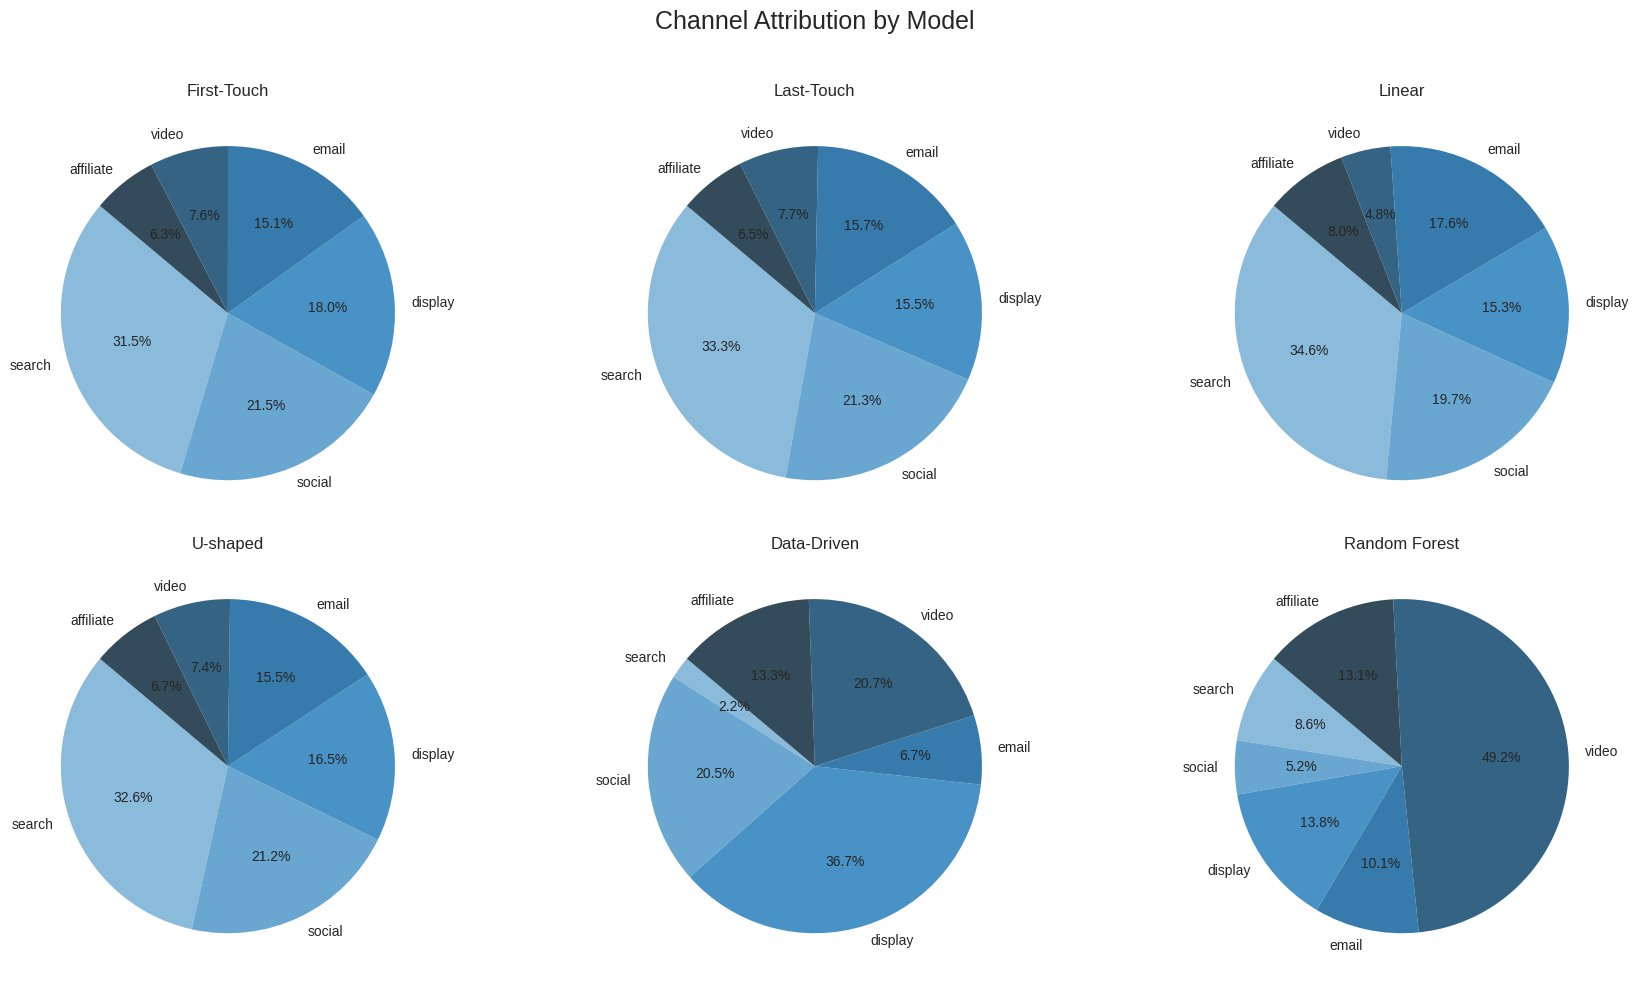

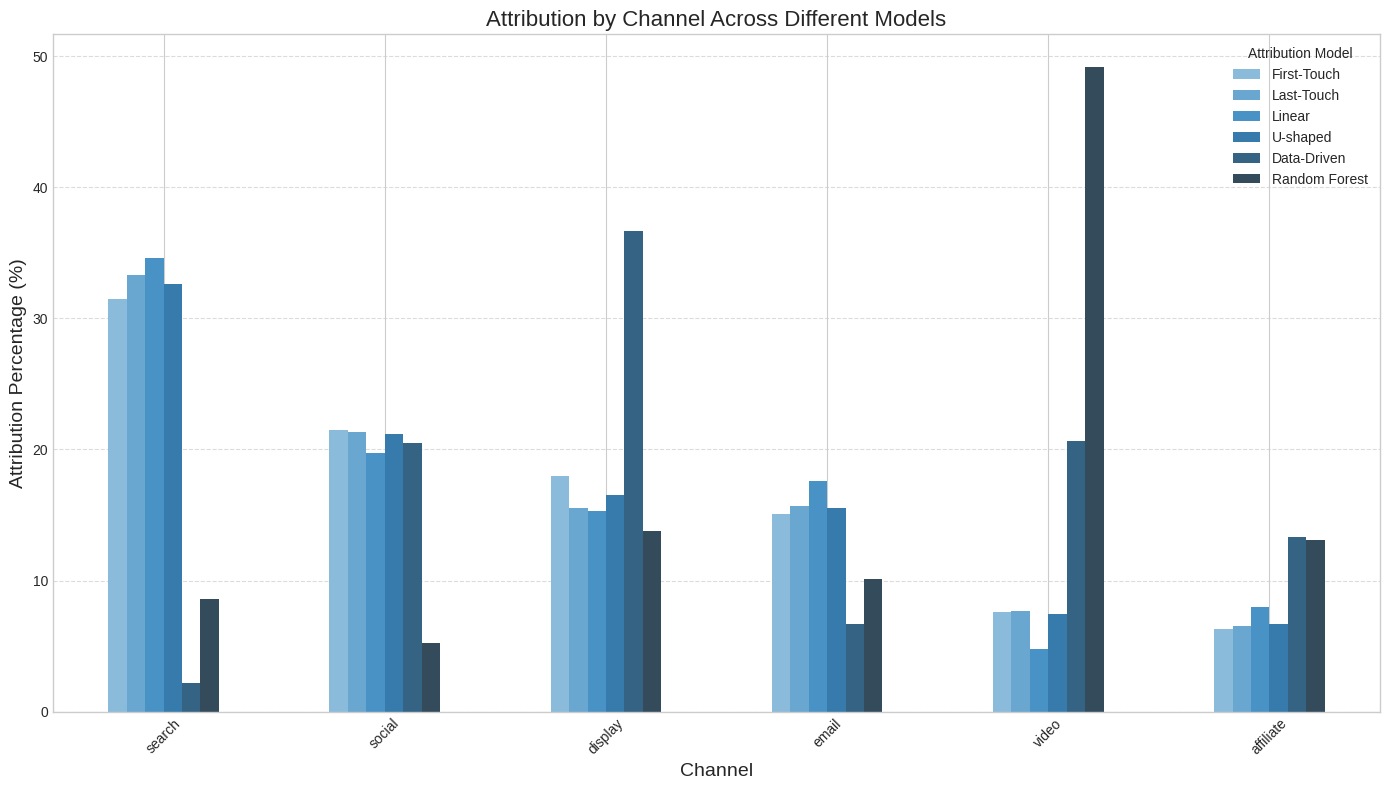

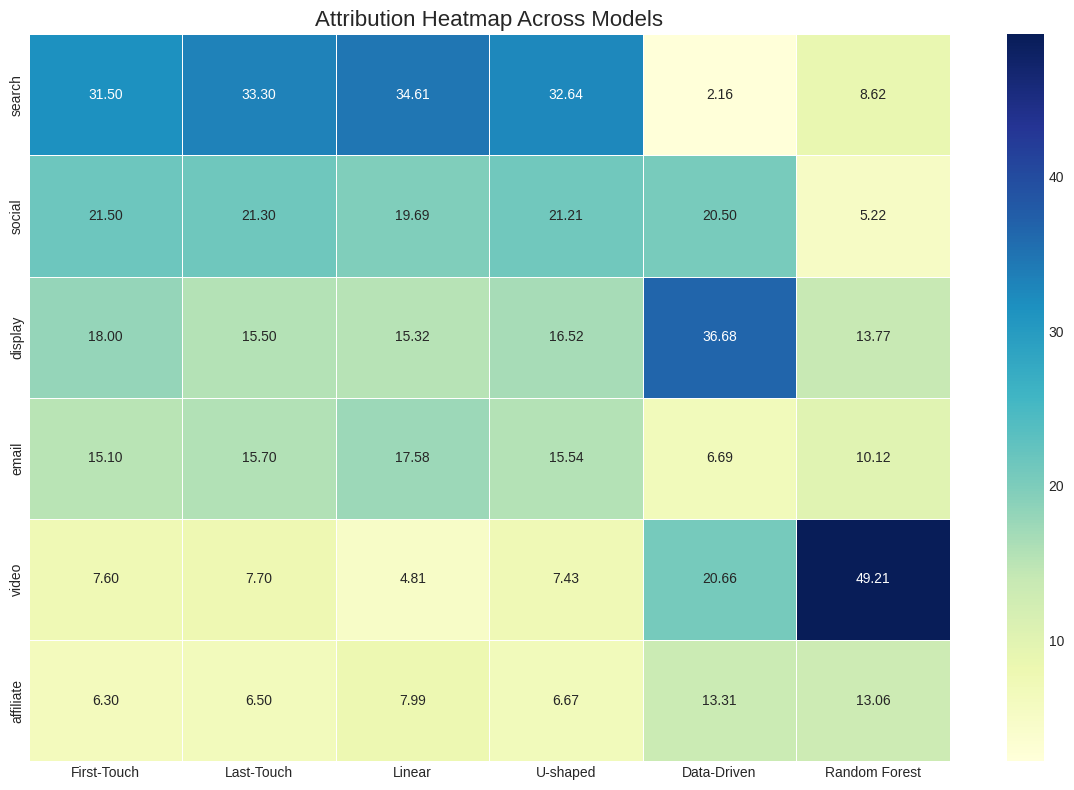

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert attribution weights to percentages for display
models_df_percent = models_df.multiply(100).round(2)

# Print formatted comparison table
print("\nComprehensive Comparison of Attribution Models (in %):")

col_width = 12  # Adjust as needed for your data

# Print header
header = f"{'Channel':<{col_width}}"
for col in models_df_percent.columns:
    header += f"{col:<{col_width}}"
print(header)
print("-" * len(header))

# Print each row with value and % sign together, right-aligned
for channel in models_df_percent.index:
    row = f"{channel:<{col_width}}"
    for col in models_df_percent.columns:
        val = models_df_percent.loc[channel, col]
        # Format as 'xx.xx%' and left-align in col_width
        row += f"{val:>6.2f} %   "
    print(row)

print("\n")
# Pie charts for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(models_df_percent.columns):
    axes[i].pie(models_df_percent[col], labels=models_df_percent.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(col)
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.suptitle("Channel Attribution by Model", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print("\n")
# Bar chart
plt.figure(figsize=(14, 8))
models_df_percent.plot(kind='bar', ax=plt.gca())
plt.title('Attribution by Channel Across Different Models', fontsize=16)
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Attribution Percentage (%)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Attribution Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("\n")
# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(models_df_percent, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title('Attribution Heatmap Across Models', fontsize=16)
plt.tight_layout()
plt.show()
